In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.image as mpimg
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    metrics,
    optimizers,
    utils,
)

# 환경 설정
IMAGE_SIZE = 28  # MNIST 기본 이미지 크기
CHANNELS = 3  # 흑백 이미지
BATCH_SIZE = 128
Z_DIM = 256
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
DATASET_PATH = 'path/to/your/dataset'

In [ ]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(images, save_to=None):
    """
    Displays and saves images using matplotlib. Assumes images are in [0, 1] range.
    """
    n = images.shape[0]
    plt.figure(figsize=(20, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i, :, :, :])  # Display RGB images directly
        plt.axis("off")
    if save_to:
        plt.savefig(save_to)
        print(f"Saved to {save_to}")
    plt.close()  # Close the figure to avoid display

In [ ]:
from tensorflow.keras.datasets import mnist

def load_mnist_data():
    (x_train, _), (_, _) = mnist.load_data()
    # 이미지를 [-1, 1] 범위로 정규화
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    # 채널 차원 추가
    x_train = np.expand_dims(x_train, axis=-1)
    # 데이터셋 구성
    train_data = tf.data.Dataset.from_tensor_slices(x_train)
    train_data = train_data.shuffle(buffer_size=1024).batch(BATCH_SIZE)
    return train_data

train = load_mnist_data()


In [ ]:
def load_custom_data(dataset_path, image_size=IMAGE_SIZE, channels=CHANNELS):
    """
    Loads images from a custom dataset folder, resizes them, and normalizes to [-1, 1] range.
    """
    image_paths = glob.glob(os.path.join(dataset_path, '*.png'))  # Modify file extension if needed
    images = []

    for image_path in image_paths:
        img = Image.open(image_path).resize((image_size, image_size))
        img = np.array(img).astype(np.float32)
        if img.shape[-1] != channels:  # Ensure the image has the correct number of channels
            continue
        img = (img - 127.5) / 127.5  # Normalize image to [-1, 1]
        images.append(img)

    images = np.array(images)
    train_data = tf.data.Dataset.from_tensor_slices(images)
    train_data = train_data.shuffle(buffer_size=1024).batch(BATCH_SIZE)
    return train_data

In [ ]:
train = load_custom_data(DATASET_PATH, IMAGE_SIZE, CHANNELS)

In [ ]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=7, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)
critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 1)             │           6,273 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,561 (541.25 KB)

 Trainable params: 138,561 (541.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
generator_input = layers.Input(shape=(Z_DIM,))
# Dense layer to upscale the input
x = layers.Dense(7 * 7 * 128, use_bias=False)(generator_input)  # 초기 특성 맵 설정 (7x7x256)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Reshape((7, 7, 128))(x)  # 7x7 feature map

# Second Transposed Conv layer to increase dimensions to 28x28
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False  # Adjusted kernel size
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.UpSampling2D()(x)

# Final Transposed Conv layer to get to the desired channel depth
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=1, padding="same", activation="tanh"  # Adjusted to match final output size exactly
)(x)

generator = models.Model(generator_input, generator_output)
generator.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6272)                │       1,605,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6272)                │          25,088 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,763,073 (6.73 MB)

 Trainable params: 1,750,401 (6.68 MB)

 Non-trainable params: 12,672 (49.50 KB)

In [ ]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
# GAN 만들기
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [ ]:
# GAN 컴파일
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [ ]:
if not os.path.exists('output'):
    os.makedirs('output')

# 콜백 정의
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 != 0:  # 출력 횟수를 줄이기 위해
            return
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 0.5 + 0.5  # Normalize images to [0, 1]
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to=f"./output/generated_img_{epoch:03d}.png",
            cmap='gray'
        )

# 모델 저장 체크포인트 및 텐서보드 콜백 설정
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
# 모델 컴파일 및 콜백 정의는 동일하게 유지
# ...

# 훈련 시작
wgangp.fit(
    train,
    epochs=EPOCHS,  # MNIST 데이터셋 크기에 맞추어 조정
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)


Epoch 1/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - c_gp: 0.0641 - c_loss: -2.3413 - c_wass_loss: -2.9819 - g_loss: -14.7335Saved to ./output/generated_img_000.png
469/469 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - c_gp: 0.0640 - c_loss: -2.3407 - c_wass_loss: -2.9804 - g_loss: -14.7294
Epoch 2/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - c_gp: 0.0260 - c_loss: -3.0142 - c_wass_loss: -3.2738 - g_loss: -5.5480
Epoch 3/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - c_gp: 0.0202 - c_loss: -2.3826 - c_wass_loss: -2.5843 - g_loss: -7.1806
Epoch 4/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - c_gp: 0.0149 - c_loss: -1.8461 - c_wass_loss: -1.9953 - g_loss: -4.7387
Epoch 5/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - c_gp: 0.0123 - c_loss: -1.5985 - c_wass_loss: -1.7213 - g_loss: -3.2017
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - c_gp: 0.0116 - c_loss: -1.5447 - c_wass_loss: -1.6604 - g_loss: -2.3363
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - c_gp: 0.0115

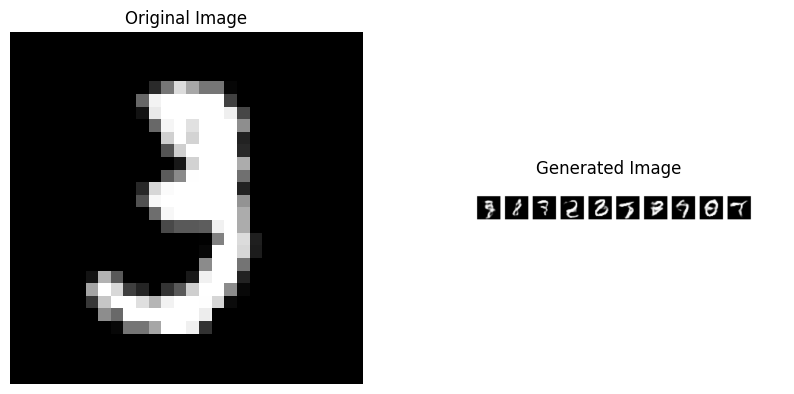

In [ ]:
# 이미지 비교 함수
def load_and_compare_images(epoch, example_index=0):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype('float32') - 127.5) / 127.5  # Normalize the images

    image_path = f"./output/generated_img_0{epoch}.png"
    if not os.path.exists(image_path):
        print("해당 경로에 이미지 파일이 없습니다:", image_path)
        return

    generated_image = mpimg.imread(image_path)
    original_image = X_train[epoch].reshape(28, 28)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(generated_image, cmap='gray')
    axs[1].set_title('Generated Image')
    axs[1].axis('off')

    plt.show()

# 예시로 40번째 에포크의 이미지 비교
load_and_compare_images(10, example_index=1)